In [1]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import vtk as vtk

In [2]:
%matplotlib notebook

# Try to load case with `pyvista.read`

In [3]:
# Import the OpenFOAM example case
case = pv.read('./case.foam')

In [4]:
mesh = case[0]

In [5]:
mesh

UnstructuredGrid (0x7f87d9ea8b20)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	26

It looks like the cas is loaded for `time=0`, I don't know how to change the time value.

Here is for example below the U field where it's 0 everywhere expect at the inlet.

In [6]:
mesh.plot(scalars='U')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Load the case with `vtkOpenFOAMReader`

In [7]:
reader = vtk.vtkOpenFOAMReader()
reader.SetFileName("cyclone_test_02_without_bl.foam")
reader.UpdateInformation()
time_array = reader.GetTimeValues()
reader.SetTimeValue(time_array.GetRange()[1])  # Set read time to latest time step
reader.Update()
multi_block = pv.wrap(reader.GetOutput())
mesh = multi_block[0]


## Let's make a simple contour plot

In [8]:
mesh.plot(scalars='U')

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

## Let's use a different and more useful API

### Show the mesh 

In [9]:
p1 = pv.Plotter()
p1.add_mesh(mesh, style="wireframe", color="w")
p1.view_xy()
p1.add_axes()
p1.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### An example with a field contour

In [10]:
p2 = pv.Plotter()
p2.add_mesh(mesh,scalars='U')
p2.view_xy()
p2.add_axes()
p2.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Another one with the mesh surimposed

In [11]:
p3 = pv.Plotter()
p3.add_mesh(mesh,scalars='U', show_edges=True)
p3.view_xy()
p3.add_axes()
p3.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

### Plot over line example

In [12]:
# Create the 2 points defining the line
a = [0, 0, 0]
b = [0, mesh.bounds[3], 0]

# Show the line in red in the domain
line = pv.Line(a, b)

p4 = pv.Plotter()
p4.view_xy()
p4.add_mesh(mesh, style="wireframe", color='white')
p4.add_mesh(line, color="r", line_width=10)
p4.add_axes()

p4.show()

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

Let's make a plot overline ...

<IPython.core.display.Javascript object>


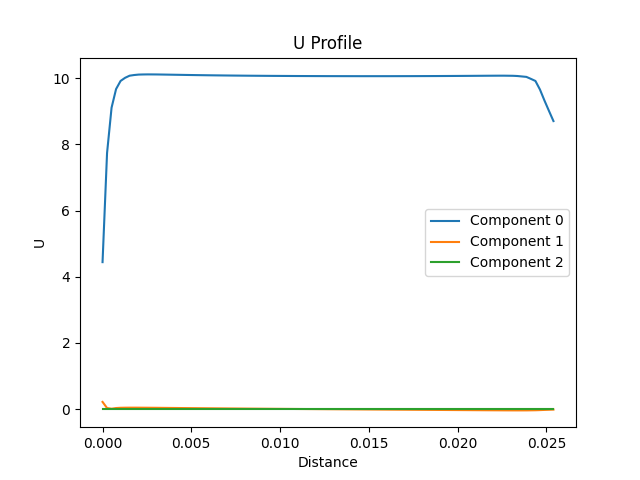

In [13]:
mesh.plot_over_line(a, b, resolution=100, scalars='U')

### How to access the vector components

In [14]:
mesh.cell_arrays

pyvista DataSetAttributes
Association: CELL
Contains keys:
	U
	epsilon
	k
	nut
	p

In [15]:
U = mesh.cell_arrays[0]
np.shape(U)

(12225, 3)

In [16]:
ux = U[:,0]
uy = U[:,1]
uz = U[:,2]

# One can also use
ux = mesh['U'][:,0]
uy = mesh['U'][:,1]
uz = mesh['U'][:,2]

<IPython.core.display.Javascript object>


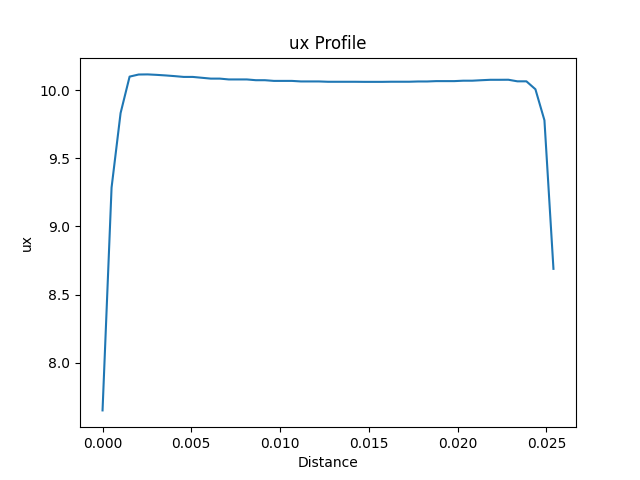

In [17]:
mesh.cell_arrays["ux"] = ux
mesh.plot_over_line(a, b, resolution=50, scalars='ux')